In [115]:
from glob import glob 
import numpy as np
import pandas as pd
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
import sklearn
import matplotlib.pyplot as plt
from PIL import Image
#from tqdm import tqdm_notebook,trange
print("done import")

done import


In [116]:
path = '/Users/yehonatanperetz/histopathologic-cancer-detection/'
train_path = '/Users/yehonatanperetz/histopathologic-cancer-detection/train/'
test_path = '/Users/yehonatanperetz/histopathologic-cancer-detection/test/'

In [117]:
all_train_df = pd.read_csv(path+"train_labels.csv")
all_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [118]:
print("Train Size: {}".format(len(os.listdir(train_path))))
print("Test Size: {}".format(len(os.listdir(test_path))))

Train Size: 220027
Test Size: 57458


In [119]:
label_counts = all_train_df.label.value_counts()
print(label_counts)



label
0    130908
1     89117
Name: count, dtype: int64


In [120]:
# Number of samples in each class
SAMPLE_SIZE = 1000


# Use 80000 positive and negative examples
df_label0 = all_train_df[all_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_label1 = all_train_df[all_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_label0, df_label1], axis=0).reset_index(drop=True))

train_df.shape

(2000, 2)

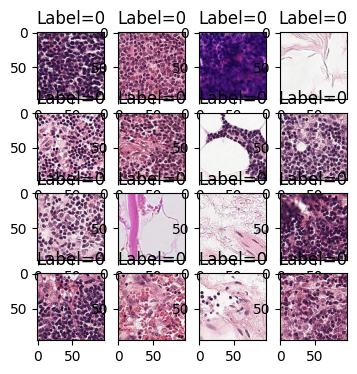

In [121]:
#print(train_df.head(2))
#print(train_imgs[1])
N_plot=4
fig = plt.figure(figsize=(N_plot, N_plot)) 

for i in range(1,N_plot**2+1):
        img=Image.open(train_path+train_df['id'][i]+'.tif')
        fig.add_subplot(N_plot, N_plot, i)
        plt.imshow(img)
        plt.title('Label=%s'%train_df['label'][i])
    

        



In [122]:
# Loading N images from df dataframe
def load_data(N,df):
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.squeeze(df['label'][0:N])
    for i in range(0,N):
        img=Image.open(train_path+df['id'][i]+'.tif')
        img_rgb = img.convert('RGB')
        X[i] = np.array(img_rgb)
    return X,y

In [123]:

X,y = load_data(N=2*SAMPLE_SIZE,df=train_df) 
print(X.shape)

(2000, 96, 96, 3)


In [124]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

(1340, 96, 96, 3)
(660, 96, 96, 3)
(1340, 1)
0


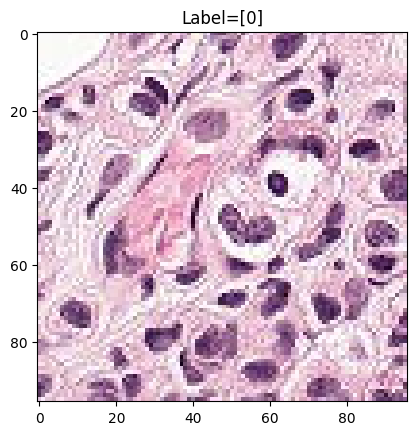

[[1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]]


In [125]:
print(X_train.shape)
N_train=len(X_train);
print(X_val.shape);
N_val=len(X_val);
y_train=np.reshape(y_train,(N_train,1))
print(y_train.shape)
k=4
print(y[k])
plt.imshow(X_train[k], cmap='hot', interpolation='nearest')
plt.title('Label='+str(y_train[k]))
plt.show()


Text(0.5, 1.0, 'Label=0')

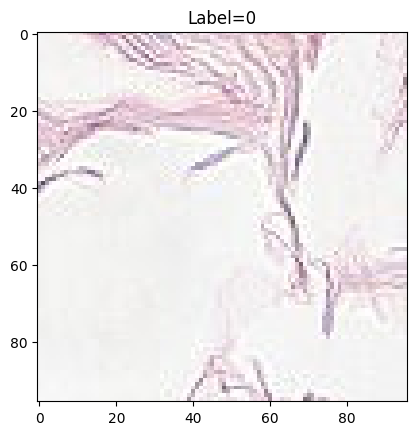

In [126]:
img=Image.open(train_path+train_df['id'][k]+'.tif')
plt.imshow(img)
plt.title('Label=%s'%train_df['label'][k])

In [146]:
#create random batches for training
batch_size=50;
N_batches=np.int32(np.floor(N_train/batch_size))
def random_batch(n, k, tot):
    start_points = np.sort(np.random.randint(0, tot-k, size=n))
    end_points = start_points + k
    end_points[:-1] = np.maximum(end_points[:-1], start_points[1:])
    return list(zip(np.int32(start_points), np.int32(end_points)))


batches=random_batch(N_batches,batch_size,N_train)
print(len(batches))
#print(batches)


26


In [179]:

img=Image.open(train_path+'lines_proto.tiff')
img_rgb = img.convert('RGB')
x0 = np.array(img_rgb)

img=Image.open(train_path+'x_proto.tiff')
img_rgb = img.convert('RGB')
x1 = np.array(img_rgb)

def generate_data(N):
# Loading N images from df dataframe
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.zeros(N);
    for i in range(0,N):
        if i%2==0:
            X[i] = x0+np.random.normal(0,1,(96,96,3))
            y[i]=np.int32(0)
        else:
            X[i] = x1+np.random.normal(0,1,(96,96,3))
            y[i]=np.int32(1)

    return X,y

In [180]:
if load_fake_data==True: 
    X,y = generate_data(N=2*SAMPLE_SIZE) 
    print(X.shape)
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

(2000, 96, 96, 3)


0.0


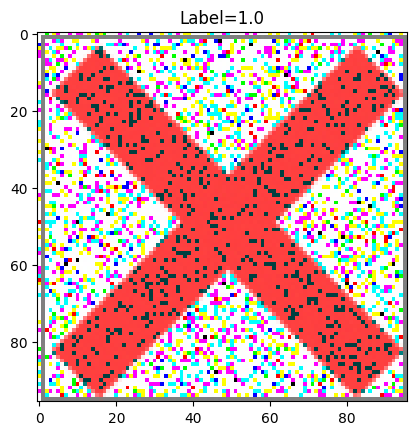

In [182]:
k=14
print(y[k])
plt.imshow(X_train[k], cmap='hot', interpolation='nearest')
plt.title('Label='+str(y_train[k]))
plt.show()

In [183]:

from keras.layers import * 
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.5
model = Sequential()
model.add(Input(shape=(96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))


model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))


model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

model.add(Dense(1, activation = "sigmoid"))

In [184]:
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_147 (Conv2D)             │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 92, 92, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 92, 92, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 44, 44, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 42, 42, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 19, 19, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 17, 17, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 17, 17, 128)    │             

 Total params: 2,386,817 (9.10 MB)

 Trainable params: 2,385,409 (9.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [185]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 64

dropout_conv = 0.1
dropout_dense = 0.1


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))



model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_153 (Conv2D)             │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_155 (Conv2D)             │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_156 (Conv2D)             │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_158 (Conv2D)             │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 17, 17, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,865 (3.10 MB)

 Trainable params: 812,865 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [186]:
model = Sequential ()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(96,96,3))) 
model.add(Conv2D(64,(3,3),activation='relu')) 
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25)) 
model.add(Conv2D(64,(3,3),activation='relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 
model.add(Conv2D(128,(3,3),activation='relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout (0.25))
model.add(Flatten()) 
model.add(Dense(64,activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [187]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.0001), 
              metrics=['accuracy'])


In [188]:
N_epochs=3;


for epoch in range(1,N_epochs+1):
    model.fit(X_train,y_train)

42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 437ms/step - accuracy: 0.7109 - loss: 12.3601
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 436ms/step - accuracy: 0.9685 - loss: 0.1254
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 440ms/step - accuracy: 0.9714 - loss: 0.0871


In [113]:
N_epochs=3;


for epoch in range(1,N_epochs+1):
    for i in range (0,N_batches-1):
        batch_start=batches[i][0]
        batch_end=batches[i][1]
        loss, acc = model.train_on_batch(X_train[batch_start:batch_end],y_train[batch_start:batch_end])
        print('Training Epoch #'+str(np.round(epoch,0))+': loss='+str(np.round(loss,2))+' accuracy='+str(np.round(acc,2))+' Progress=',str(np.round(i*100/N_batches))+'%',end='\r')
    print('Training Epoch #'+str(np.round(epoch,0))+': loss='+str(np.round(loss,2))+' accuracy='+str(np.round(acc,2)))  

model.save(path+'/model1.keras') 



Training Epoch #1: loss=0.69 accuracy=0.51 Progress= 92.0%
Training Epoch #2: loss=0.69 accuracy=0.51 Progress= 92.0%
Training Epoch #3: loss=0.69 accuracy=0.51 Progress= 92.0%


In [81]:
i


50

In [82]:
batches[50][0]

IndexError: list index out of range

In [83]:
N_batches


134